# Variational Autoencoder (VAE) from Scratch in PyTorch

This notebook demonstrates how to build a Variational Autoencoder (VAE) for the MNIST dataset using PyTorch. We will implement the core components by hand and explain the connection between the code and the underlying theory and equations.

## 1. Introduction to VAEs

Variational Autoencoders (VAEs) are generative models that learn a probability distribution over the input data. They consist of two main parts:

1.  **Encoder (Recognition Model):** $q_\phi(z|x)$. This network takes an input $x$ and outputs parameters (typically mean $\mu$ and log-variance $\log \sigma^2$) for a probability distribution in the latent space, $z$. This distribution approximates the true posterior $p(z|x)$.
2.  **Decoder (Generative Model):** $p_\theta(x|z)$. This network takes a sample $z$ from the latent distribution and reconstructs the input data $x$.

The goal of a VAE is to maximize the **Evidence Lower Bound (ELBO)**, which is a lower bound on the log-likelihood of the data $\log p(x)$:

$$ \mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p(z)) $$

Where:
- The first term, $\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$, is the **reconstruction loss**. It encourages the decoder to accurately reconstruct the input $x$ from the latent representation $z$.
- The second term, $D_{KL}(q_\phi(z|x) || p(z))$, is the **Kullback-Leibler (KL) divergence** between the approximate posterior $q_\phi(z|x)$ learned by the encoder and a prior distribution $p(z)$ over the latent variables (usually a standard normal distribution, $\mathcal{N}(0, I)$). This term acts as a regularizer, forcing the latent space to be well-behaved (e.g., continuous and centered around the origin).

## 2. Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 3. Hyperparameters and Device Configuration

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 128
EPOCHS = 50 # Increase for better results, e.g., 20-50
LEARNING_RATE = 1e-3
INPUT_DIM = 28 * 28  # MNIST image dimensions (flattened)
LATENT_DIM = 2    # Dimension of the latent space z
# For visualizing 2D latent space (optional, set LATENT_DIM=2 for this)

ENCODER_HIDDEN_DIMS = [256,128,64]
DECODER_HIDDEN_DIMS = [64,128,256] # Symmetric

Using device: cuda


## 4. Data Loading (MNIST)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] tensor
    # transforms.Normalize((0.1307,), (0.3081,)) # Optional: Standard MNIST normalization
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 5. VAE Model Definition

We'll define the VAE as a `nn.Module`.

### 5.1 Encoder Network: $q_\phi(z|x)$

The encoder network takes an input image $x$ and maps it to the parameters of a Gaussian distribution in the latent space. Specifically, it outputs a mean vector $\mu_z$ and a log-variance vector $\log(\sigma_z^2)$. We use log-variance for numerical stability and to ensure $\sigma_z^2$ is always positive.

Structure:
1.  Input layer (flattened image)
2.  One or more hidden layers (e.g., with ReLU activation)
3.  Two separate linear output layers: one for $\mu_z$ and one for $\log(\sigma_z^2)$.

The output of the encoder defines $q_\phi(z|x) = \mathcal{N}(z; \mu_z, \text{diag}(\sigma_z^2))$.

### 5.2 Reparameterization Trick

To train the VAE using backpropagation, we need to sample $z$ from $q_\phi(z|x)$. However, the sampling operation itself is stochastic and non-differentiable. The **reparameterization trick** allows us to re-express the sampling process in a way that makes it differentiable.

Instead of sampling $z \sim \mathcal{N}(\mu_z, \sigma_z^2)$, we sample a noise variable $\epsilon \sim \mathcal{N}(0, I)$ (a standard normal distribution, which is parameter-free) and then compute $z$ as:

$$ z = \mu_z + \sigma_z \odot \epsilon $$

Here, $\odot$ denotes element-wise multiplication. Since $\sigma_z = \exp(0.5 \cdot \log(\sigma_z^2))$, the equation becomes:

$$ z = \mu_z + \exp(0.5 \cdot \log(\sigma_z^2)) \odot \epsilon $$

Now, the stochasticity comes from $\epsilon$, which is an input to this computation. The transformation from $\epsilon$, $\mu_z$, and $\log(\sigma_z^2)$ to $z$ is deterministic, allowing gradients to flow back through $\mu_z$ and $\log(\sigma_z^2)$ to the encoder parameters $\phi$.

### 5.3 Decoder Network: $p_\theta(x|z)$

The decoder network takes a latent sample $z$ and maps it back to the data space, aiming to reconstruct the original input $x$. Its output, $\hat{x}$, represents the parameters of the distribution $p_\theta(x|z)$. For MNIST, where pixel values are typically between 0 and 1, we often model $p_\theta(x|z)$ as a Bernoulli distribution for each pixel. The decoder outputs the probability parameter for each pixel, often using a sigmoid activation function.

Structure:
1.  Input layer (latent vector $z$)
2.  One or more hidden layers (e.g., with ReLU activation)
3.  Output layer (reconstructed image, with sigmoid activation for pixel values in [0,1]).

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_hidden_dims, latent_dim, decoder_hidden_dims):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # === Encoder Part ===
        # q_phi(z|x)
        encoder_layers = []
        in_dim = input_dim
        for h_dim in encoder_hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            # encoder_layers.append(nn.BatchNorm1d(h_dim)) # Optional: BatchNorm
            # encoder_layers.append(nn.Dropout(0.2))      # Optional: Dropout
            in_dim = h_dim
        self.encoder_net = nn.Sequential(*encoder_layers)

        # From the last encoder hidden layer to mu and log_var
        self.fc_mu = nn.Linear(in_dim, latent_dim)
        self.fc_log_var = nn.Linear(in_dim, latent_dim)

        # === Decoder Part ===
        # p_theta(x|z)
        decoder_layers = []
        in_dim_decoder = latent_dim
        for h_dim in decoder_hidden_dims:
            decoder_layers.append(nn.Linear(in_dim_decoder, h_dim))
            decoder_layers.append(nn.ReLU())
            # decoder_layers.append(nn.BatchNorm1d(h_dim)) # Optional
            # decoder_layers.append(nn.Dropout(0.2))      # Optional
            in_dim_decoder = h_dim
        self.decoder_net = nn.Sequential(*decoder_layers)

        # From the last decoder hidden layer to reconstructed x
        self.fc_output = nn.Linear(in_dim_decoder, input_dim)

    def encode(self, x):
        h_encoder = self.encoder_net(x)
        mu = self.fc_mu(h_encoder)
        log_var = self.fc_log_var(h_encoder)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h_decoder = self.decoder_net(z)
        recon_x = torch.sigmoid(self.fc_output(h_decoder))
        return recon_x

    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        mu, log_var = self.encode(x_flat)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var

# --- Instantiate the model with dynamic hidden layers ---
model = VAE(INPUT_DIM, ENCODER_HIDDEN_DIMS, LATENT_DIM, DECODER_HIDDEN_DIMS).to(DEVICE)
print(model) # Print model structure to verify

VAE(
  (encoder_net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=64, out_features=2, bias=True)
  (decoder_net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
  )
  (fc_output): Linear(in_features=256, out_features=784, bias=True)
)


## 6. Loss Function (ELBO)

As mentioned, we want to maximize the ELBO:
$$ \mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p(z)) $$

In practice, we minimize the negative ELBO:
$$ -\mathcal{L} = -\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] + D_{KL}(q_\phi(z|x) || p(z)) $$

This is often written as:
$$ \text{Loss} = \text{Reconstruction Loss} + \text{KL Divergence} $$

1.  **Reconstruction Loss**: For Bernoulli distributed outputs (pixel values in [0,1] from sigmoid), the term $-\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$ becomes the **Binary Cross-Entropy (BCE)** between the original input $x$ and the reconstructed output $\hat{x}$ (which are the Bernoulli parameters from the decoder).
    
    $$ \text{BCE}(x, \hat{x}) = - \sum_{i=1}^{\text{dim}(x)} [x_i \log(\hat{x}_i) + (1-x_i) \log(1-\hat{x}_i)] $$
    PyTorch's `F.binary_cross_entropy` with `reduction='sum'` calculates this.

2.  **KL Divergence**: The KL divergence between $q_\phi(z|x) = \mathcal{N}(\mu_z, \text{diag}(\sigma_z^2))$ and the prior $p(z) = \mathcal{N}(0, I)$ has an analytical solution:
    
    $$ D_{KL}(\mathcal{N}(\mu_z, \sigma_z^2) || \mathcal{N}(0, I)) = -0.5 \sum_{j=1}^{\text{LATENT DIM}} (1 + \log(\sigma_{z,j}^2) - \mu_{z,j}^2 - \sigma_{z,j}^2) $$
    Where $j$ indexes the dimensions of the latent space. Remember $\sigma_{z,j}^2 = \exp(\log(\sigma_{z,j}^2))$.

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    """
    Computes the VAE loss, which is the sum of reconstruction loss and KL divergence.
    recon_x: a tensor of shape (batch_size, input_dim) - reconstructed input
    x: a tensor of shape (batch_size, input_dim) - original input
    mu: a tensor of shape (batch_size, latent_dim) - latent mean
    log_var: a tensor of shape (batch_size, latent_dim) - latent log variance
    """
    # 1. Reconstruction Loss (Binary Cross Entropy)
    # We use F.binary_cross_entropy. It expects recon_x (probabilities) and x (binary targets).
    # The sum over dimensions is important for proper weighting against KLD.
    # x.view(-1, INPUT_DIM) ensures x is flattened just like recon_x
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_DIM), reduction='sum')

    # 2. KL Divergence
    # D_KL(q_phi(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 = exp(log_var)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss
    return BCE + KLD

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 7. Training Loop

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.702759
Train Epoch: 1 [12800/60000 (21%)]	Loss: 195.894379
Train Epoch: 1 [25600/60000 (43%)]	Loss: 185.133957
Train Epoch: 1 [38400/60000 (64%)]	Loss: 182.914627
Train Epoch: 1 [51200/60000 (85%)]	Loss: 169.893219
====> Epoch: 1 Average loss: 198.8902
====> Test set loss: 174.6918
Train Epoch: 2 [0/60000 (0%)]	Loss: 180.904633
Train Epoch: 2 [12800/60000 (21%)]	Loss: 180.465088
Train Epoch: 2 [25600/60000 (43%)]	Loss: 174.474228
Train Epoch: 2 [38400/60000 (64%)]	Loss: 166.900421
Train Epoch: 2 [51200/60000 (85%)]	Loss: 164.754425
====> Epoch: 2 Average loss: 169.1873
====> Test set loss: 165.3139
Train Epoch: 3 [0/60000 (0%)]	Loss: 164.962097
Train Epoch: 3 [12800/60000 (21%)]	Loss: 161.904068
Train Epoch: 3 [25600/60000 (43%)]	Loss: 160.897675
Train Epoch: 3 [38400/60000 (64%)]	Loss: 166.482071
Train Epoch: 3 [51200/60000 (85%)]	Loss: 155.648621
====> Epoch: 3 Average loss: 161.9824
====> Test set loss: 158.4286
Train Epoch: 4 [0/60000 (0%)]	L

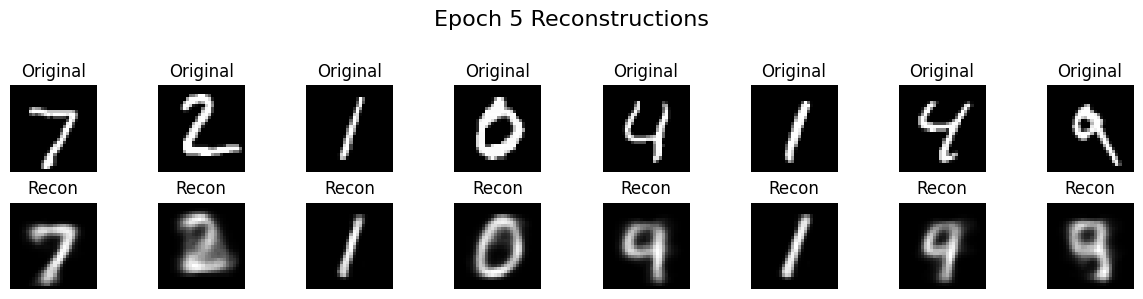

====> Test set loss: 151.4520
Train Epoch: 6 [0/60000 (0%)]	Loss: 145.574600
Train Epoch: 6 [12800/60000 (21%)]	Loss: 147.830994
Train Epoch: 6 [25600/60000 (43%)]	Loss: 158.977814
Train Epoch: 6 [38400/60000 (64%)]	Loss: 156.775101
Train Epoch: 6 [51200/60000 (85%)]	Loss: 154.063446
====> Epoch: 6 Average loss: 150.2818
====> Test set loss: 149.4964
Train Epoch: 7 [0/60000 (0%)]	Loss: 150.364471
Train Epoch: 7 [12800/60000 (21%)]	Loss: 150.925659
Train Epoch: 7 [25600/60000 (43%)]	Loss: 151.474091
Train Epoch: 7 [38400/60000 (64%)]	Loss: 154.343277
Train Epoch: 7 [51200/60000 (85%)]	Loss: 147.266342
====> Epoch: 7 Average loss: 148.3721
====> Test set loss: 147.7653
Train Epoch: 8 [0/60000 (0%)]	Loss: 150.852112
Train Epoch: 8 [12800/60000 (21%)]	Loss: 148.911880
Train Epoch: 8 [25600/60000 (43%)]	Loss: 151.964966
Train Epoch: 8 [38400/60000 (64%)]	Loss: 146.612350
Train Epoch: 8 [51200/60000 (85%)]	Loss: 147.097916
====> Epoch: 8 Average loss: 147.4142
====> Test set loss: 147.5021
T

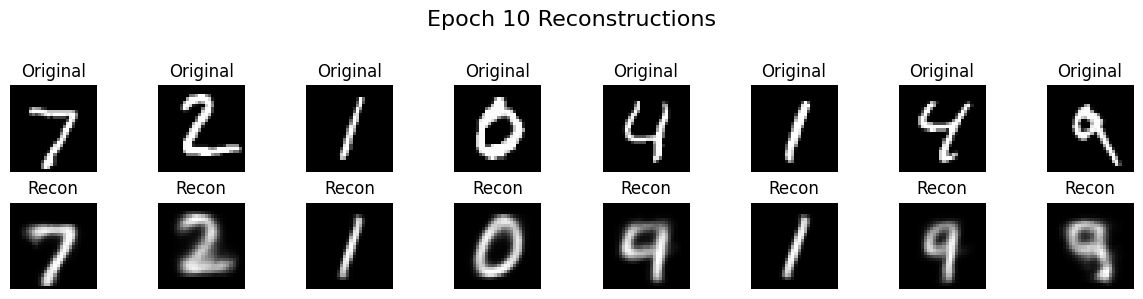

====> Test set loss: 145.2573
Train Epoch: 11 [0/60000 (0%)]	Loss: 140.642548
Train Epoch: 11 [12800/60000 (21%)]	Loss: 143.470200
Train Epoch: 11 [25600/60000 (43%)]	Loss: 146.177521
Train Epoch: 11 [38400/60000 (64%)]	Loss: 142.008560
Train Epoch: 11 [51200/60000 (85%)]	Loss: 148.129517
====> Epoch: 11 Average loss: 144.4882
====> Test set loss: 144.5151
Train Epoch: 12 [0/60000 (0%)]	Loss: 140.724518
Train Epoch: 12 [12800/60000 (21%)]	Loss: 140.465027
Train Epoch: 12 [25600/60000 (43%)]	Loss: 146.957382
Train Epoch: 12 [38400/60000 (64%)]	Loss: 138.937439
Train Epoch: 12 [51200/60000 (85%)]	Loss: 143.253220
====> Epoch: 12 Average loss: 144.2434
====> Test set loss: 143.9219
Train Epoch: 13 [0/60000 (0%)]	Loss: 140.647949
Train Epoch: 13 [12800/60000 (21%)]	Loss: 135.569992
Train Epoch: 13 [25600/60000 (43%)]	Loss: 137.952347
Train Epoch: 13 [38400/60000 (64%)]	Loss: 141.476364
Train Epoch: 13 [51200/60000 (85%)]	Loss: 148.147034
====> Epoch: 13 Average loss: 143.5086
====> Test se

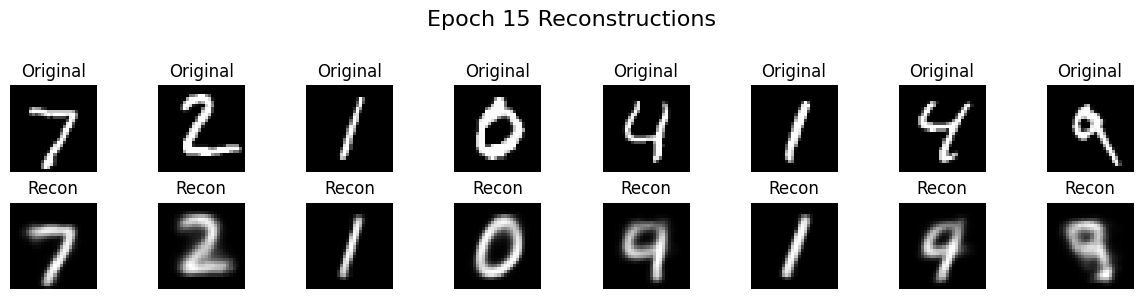

====> Test set loss: 142.4525
Train Epoch: 16 [0/60000 (0%)]	Loss: 141.967560
Train Epoch: 16 [12800/60000 (21%)]	Loss: 141.248550
Train Epoch: 16 [25600/60000 (43%)]	Loss: 144.900925
Train Epoch: 16 [38400/60000 (64%)]	Loss: 140.120834
Train Epoch: 16 [51200/60000 (85%)]	Loss: 145.594696
====> Epoch: 16 Average loss: 141.7577
====> Test set loss: 142.0190
Train Epoch: 17 [0/60000 (0%)]	Loss: 140.525238
Train Epoch: 17 [12800/60000 (21%)]	Loss: 132.522659
Train Epoch: 17 [25600/60000 (43%)]	Loss: 136.713348
Train Epoch: 17 [38400/60000 (64%)]	Loss: 137.951477
Train Epoch: 17 [51200/60000 (85%)]	Loss: 139.331085
====> Epoch: 17 Average loss: 142.1240
====> Test set loss: 142.3589
Train Epoch: 18 [0/60000 (0%)]	Loss: 144.086227
Train Epoch: 18 [12800/60000 (21%)]	Loss: 141.976120
Train Epoch: 18 [25600/60000 (43%)]	Loss: 137.228851
Train Epoch: 18 [38400/60000 (64%)]	Loss: 140.646530
Train Epoch: 18 [51200/60000 (85%)]	Loss: 135.797226
====> Epoch: 18 Average loss: 141.5601
====> Test se

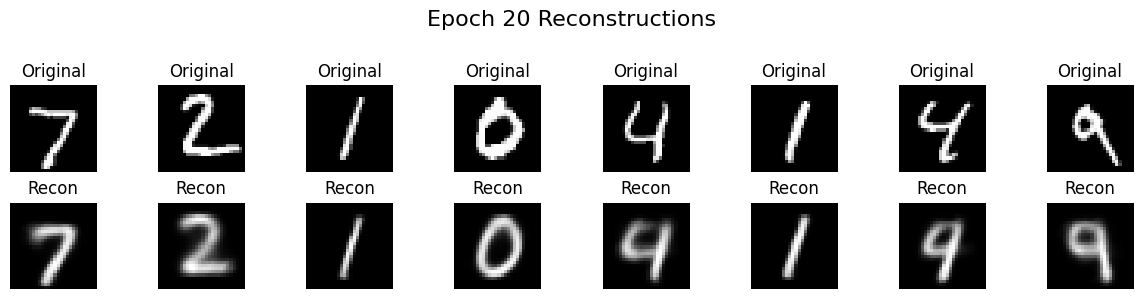

====> Test set loss: 142.8442
Train Epoch: 21 [0/60000 (0%)]	Loss: 145.475998
Train Epoch: 21 [12800/60000 (21%)]	Loss: 145.953827
Train Epoch: 21 [25600/60000 (43%)]	Loss: 139.641235
Train Epoch: 21 [38400/60000 (64%)]	Loss: 142.417908
Train Epoch: 21 [51200/60000 (85%)]	Loss: 142.188248
====> Epoch: 21 Average loss: 141.2569
====> Test set loss: 141.3923
Train Epoch: 22 [0/60000 (0%)]	Loss: 138.374146
Train Epoch: 22 [12800/60000 (21%)]	Loss: 133.867569
Train Epoch: 22 [25600/60000 (43%)]	Loss: 137.417068
Train Epoch: 22 [38400/60000 (64%)]	Loss: 140.631851
Train Epoch: 22 [51200/60000 (85%)]	Loss: 139.483688
====> Epoch: 22 Average loss: 140.3929
====> Test set loss: 141.2671
Train Epoch: 23 [0/60000 (0%)]	Loss: 139.147842
Train Epoch: 23 [12800/60000 (21%)]	Loss: 138.840134
Train Epoch: 23 [25600/60000 (43%)]	Loss: 146.122818
Train Epoch: 23 [38400/60000 (64%)]	Loss: 135.577591
Train Epoch: 23 [51200/60000 (85%)]	Loss: 146.933884
====> Epoch: 23 Average loss: 140.2955
====> Test se

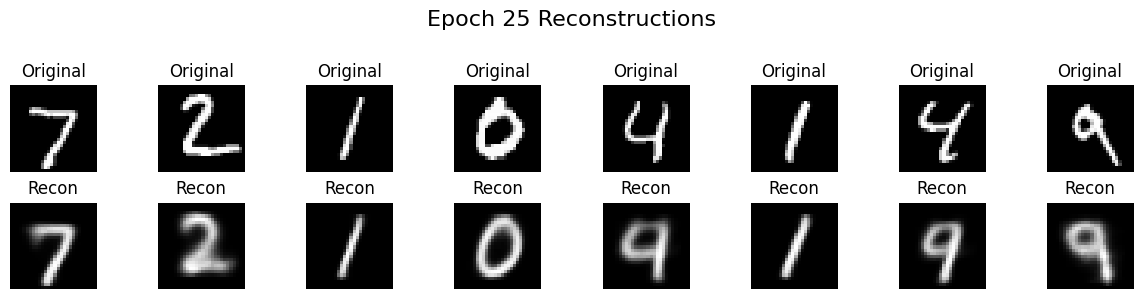

====> Test set loss: 140.7215
Train Epoch: 26 [0/60000 (0%)]	Loss: 141.668488
Train Epoch: 26 [12800/60000 (21%)]	Loss: 143.648956
Train Epoch: 26 [25600/60000 (43%)]	Loss: 145.816208
Train Epoch: 26 [38400/60000 (64%)]	Loss: 139.838242
Train Epoch: 26 [51200/60000 (85%)]	Loss: 143.549591
====> Epoch: 26 Average loss: 139.7311
====> Test set loss: 140.8842
Train Epoch: 27 [0/60000 (0%)]	Loss: 144.619598
Train Epoch: 27 [12800/60000 (21%)]	Loss: 145.505432
Train Epoch: 27 [25600/60000 (43%)]	Loss: 133.878952
Train Epoch: 27 [38400/60000 (64%)]	Loss: 145.620880
Train Epoch: 27 [51200/60000 (85%)]	Loss: 139.664169
====> Epoch: 27 Average loss: 139.8333
====> Test set loss: 140.0855
Train Epoch: 28 [0/60000 (0%)]	Loss: 137.750900
Train Epoch: 28 [12800/60000 (21%)]	Loss: 136.084747
Train Epoch: 28 [25600/60000 (43%)]	Loss: 137.073593
Train Epoch: 28 [38400/60000 (64%)]	Loss: 134.561005
Train Epoch: 28 [51200/60000 (85%)]	Loss: 136.337097
====> Epoch: 28 Average loss: 139.2616
====> Test se

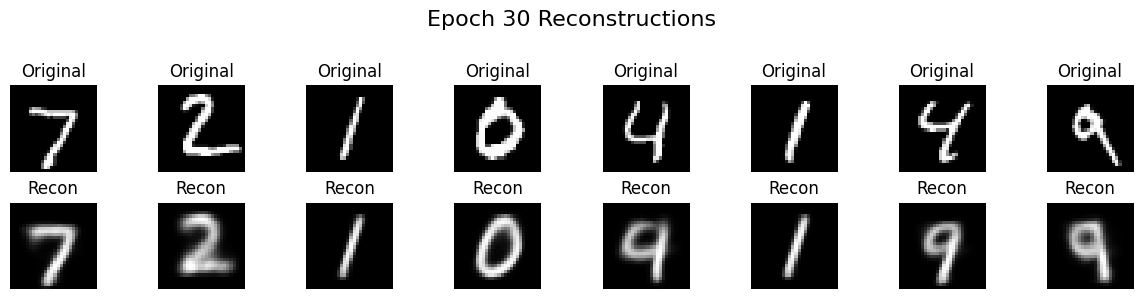

====> Test set loss: 140.5563
Train Epoch: 31 [0/60000 (0%)]	Loss: 144.560242
Train Epoch: 31 [12800/60000 (21%)]	Loss: 139.414505
Train Epoch: 31 [25600/60000 (43%)]	Loss: 139.239105
Train Epoch: 31 [38400/60000 (64%)]	Loss: 136.354370
Train Epoch: 31 [51200/60000 (85%)]	Loss: 137.710190
====> Epoch: 31 Average loss: 139.6328
====> Test set loss: 140.6004
Train Epoch: 32 [0/60000 (0%)]	Loss: 141.817200
Train Epoch: 32 [12800/60000 (21%)]	Loss: 136.400375
Train Epoch: 32 [25600/60000 (43%)]	Loss: 133.933151
Train Epoch: 32 [38400/60000 (64%)]	Loss: 142.225281
Train Epoch: 32 [51200/60000 (85%)]	Loss: 129.851486
====> Epoch: 32 Average loss: 139.5345
====> Test set loss: 139.9207
Train Epoch: 33 [0/60000 (0%)]	Loss: 147.927689
Train Epoch: 33 [12800/60000 (21%)]	Loss: 132.275101
Train Epoch: 33 [25600/60000 (43%)]	Loss: 133.802094
Train Epoch: 33 [38400/60000 (64%)]	Loss: 136.735229
Train Epoch: 33 [51200/60000 (85%)]	Loss: 143.383942
====> Epoch: 33 Average loss: 138.7193
====> Test se

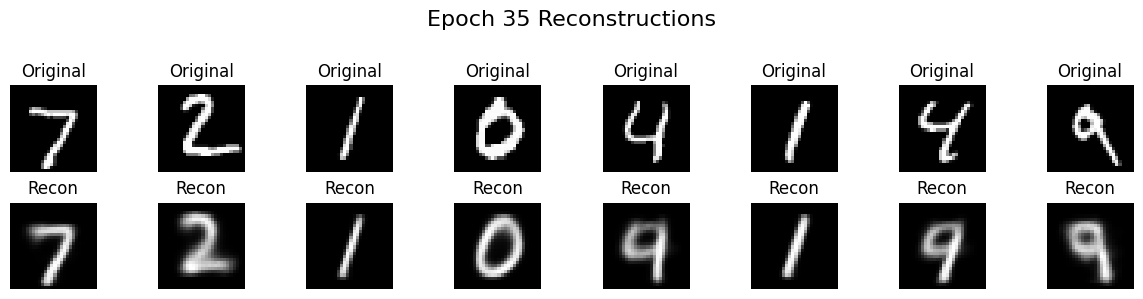

====> Test set loss: 139.9080
Train Epoch: 36 [0/60000 (0%)]	Loss: 145.548157
Train Epoch: 36 [12800/60000 (21%)]	Loss: 142.491455
Train Epoch: 36 [25600/60000 (43%)]	Loss: 140.772049
Train Epoch: 36 [38400/60000 (64%)]	Loss: 134.845016
Train Epoch: 36 [51200/60000 (85%)]	Loss: 142.196640
====> Epoch: 36 Average loss: 138.1671
====> Test set loss: 139.2104
Train Epoch: 37 [0/60000 (0%)]	Loss: 141.456375
Train Epoch: 37 [12800/60000 (21%)]	Loss: 130.806427
Train Epoch: 37 [25600/60000 (43%)]	Loss: 133.893143
Train Epoch: 37 [38400/60000 (64%)]	Loss: 137.734558
Train Epoch: 37 [51200/60000 (85%)]	Loss: 141.990021
====> Epoch: 37 Average loss: 137.9750
====> Test set loss: 138.9310
Train Epoch: 38 [0/60000 (0%)]	Loss: 131.273331
Train Epoch: 38 [12800/60000 (21%)]	Loss: 140.069977
Train Epoch: 38 [25600/60000 (43%)]	Loss: 137.745956
Train Epoch: 38 [38400/60000 (64%)]	Loss: 141.607101
Train Epoch: 38 [51200/60000 (85%)]	Loss: 140.485474
====> Epoch: 38 Average loss: 137.9337
====> Test se

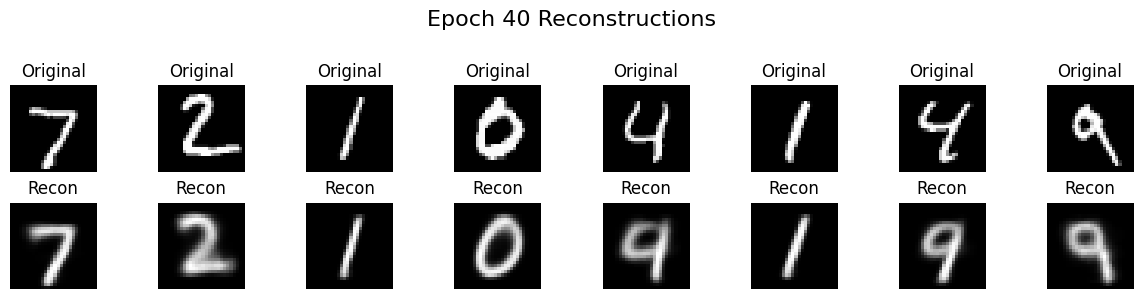

====> Test set loss: 138.6600
Train Epoch: 41 [0/60000 (0%)]	Loss: 137.415649
Train Epoch: 41 [12800/60000 (21%)]	Loss: 133.954239
Train Epoch: 41 [25600/60000 (43%)]	Loss: 137.668945
Train Epoch: 41 [38400/60000 (64%)]	Loss: 132.803604
Train Epoch: 41 [51200/60000 (85%)]	Loss: 137.765823
====> Epoch: 41 Average loss: 137.6609
====> Test set loss: 139.0659
Train Epoch: 42 [0/60000 (0%)]	Loss: 143.591553
Train Epoch: 42 [12800/60000 (21%)]	Loss: 127.769630
Train Epoch: 42 [25600/60000 (43%)]	Loss: 134.344254
Train Epoch: 42 [38400/60000 (64%)]	Loss: 136.419647
Train Epoch: 42 [51200/60000 (85%)]	Loss: 142.439331
====> Epoch: 42 Average loss: 138.1303
====> Test set loss: 139.8133
Train Epoch: 43 [0/60000 (0%)]	Loss: 142.373749
Train Epoch: 43 [12800/60000 (21%)]	Loss: 138.160034
Train Epoch: 43 [25600/60000 (43%)]	Loss: 135.319199
Train Epoch: 43 [38400/60000 (64%)]	Loss: 136.368866
Train Epoch: 43 [51200/60000 (85%)]	Loss: 136.181732
====> Epoch: 43 Average loss: 138.1081
====> Test se

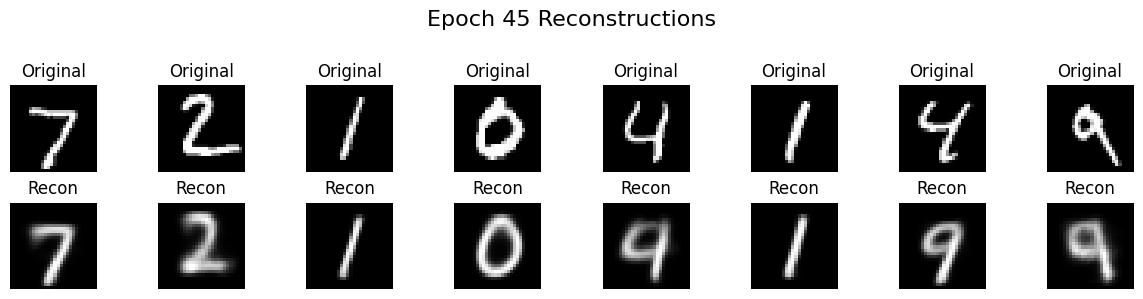

====> Test set loss: 139.8164
Train Epoch: 46 [0/60000 (0%)]	Loss: 135.067581
Train Epoch: 46 [12800/60000 (21%)]	Loss: 136.177673
Train Epoch: 46 [25600/60000 (43%)]	Loss: 133.950790
Train Epoch: 46 [38400/60000 (64%)]	Loss: 137.720551
Train Epoch: 46 [51200/60000 (85%)]	Loss: 135.778915
====> Epoch: 46 Average loss: 138.1827
====> Test set loss: 138.7747
Train Epoch: 47 [0/60000 (0%)]	Loss: 131.272522
Train Epoch: 47 [12800/60000 (21%)]	Loss: 143.134033
Train Epoch: 47 [25600/60000 (43%)]	Loss: 135.499146
Train Epoch: 47 [38400/60000 (64%)]	Loss: 131.583740
Train Epoch: 47 [51200/60000 (85%)]	Loss: 143.339432
====> Epoch: 47 Average loss: 137.8802
====> Test set loss: 139.8758
Train Epoch: 48 [0/60000 (0%)]	Loss: 139.380920
Train Epoch: 48 [12800/60000 (21%)]	Loss: 138.943253
Train Epoch: 48 [25600/60000 (43%)]	Loss: 133.638199
Train Epoch: 48 [38400/60000 (64%)]	Loss: 137.815735
Train Epoch: 48 [51200/60000 (85%)]	Loss: 137.285645
====> Epoch: 48 Average loss: 137.6274
====> Test se

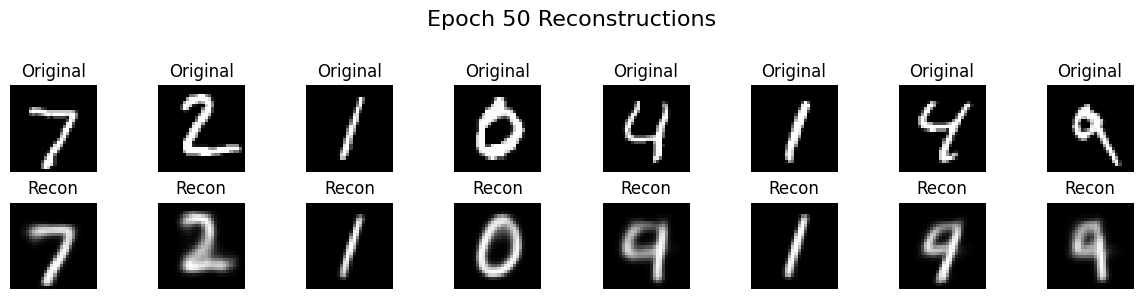

====> Test set loss: 138.6820


In [ ]:
def train(epoch):
    model.train() # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader): # We don't need labels for VAE
        data = data.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, log_var = model(data)

        # Calculate loss
        loss = loss_function(recon_batch, data, mu, log_var)

        # Backward pass and optimize
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')
    return avg_train_loss

def test(epoch):
    model.eval() # Set model to evaluation mode
    test_loss = 0
    with torch.no_grad(): # No gradients needed for evaluation
        for i, (data, _) in enumerate(test_loader):
            data = data.to(DEVICE)
            recon_batch, mu, log_var = model(data)
            test_loss += loss_function(recon_batch, data, mu, log_var).item()

            # For the first batch in the first epoch, save original and reconstructed images for visualization
            if i == 0 and epoch % 5 == 0: # Show every 5 epochs
                n = min(data.size(0), 8) # Display up to 8 images
                comparison = torch.cat([data[:n].view(-1, 1, 28, 28), # Original
                                      recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]]) # Reconstructed
                # Convert to numpy for plotting
                comparison_np = comparison.cpu().numpy().squeeze()

                fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
                for img_idx in range(n):
                    axes[0, img_idx].imshow(comparison_np[img_idx], cmap='gray')
                    axes[0, img_idx].set_title("Original")
                    axes[0, img_idx].axis('off')
                    axes[1, img_idx].imshow(comparison_np[n+img_idx], cmap='gray')
                    axes[1, img_idx].set_title("Recon")
                    axes[1, img_idx].axis('off')
                plt.suptitle(f"Epoch {epoch} Reconstructions", fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f'====> Test set loss: {avg_test_loss:.4f}')
    return avg_test_loss

# Start training
train_losses = []
test_losses = []
for epoch in range(1, EPOCHS + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

## 8. Visualizing Results

### 8.1 Loss Curves

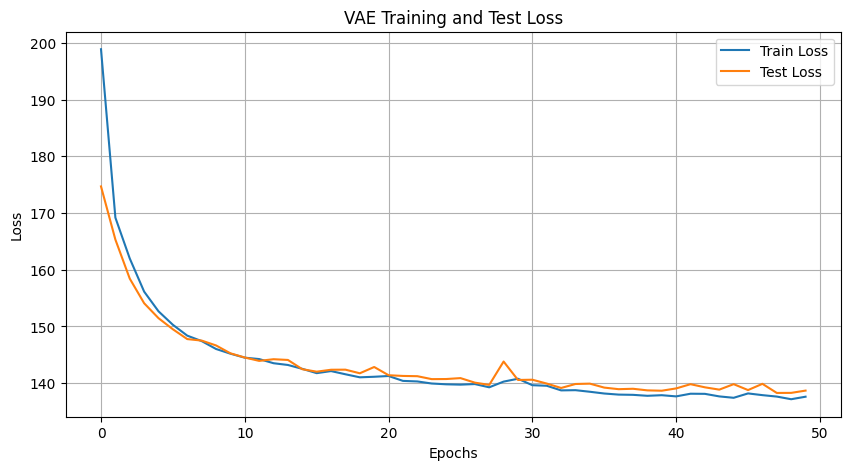

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('VAE Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 8.2 Generating New Samples

To generate new samples, we sample $z$ from the prior distribution $p(z) = \mathcal{N}(0, I)$ and pass it through the decoder $p_\theta(x|z)$.

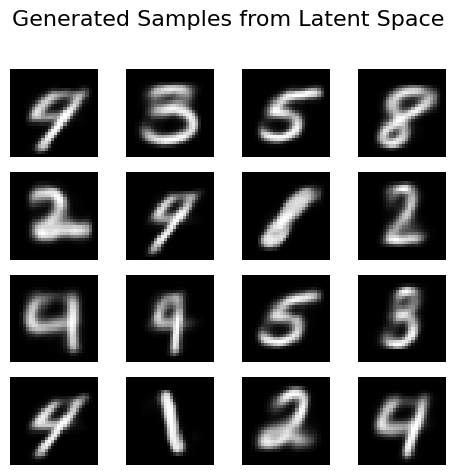

In [ ]:
def generate_samples(num_samples=64):
    model.eval()
    with torch.no_grad():
        # Sample z from the prior N(0, I)
        z_sample = torch.randn(num_samples, LATENT_DIM).to(DEVICE)
        # Decode z to generate new images
        generated_images = model.decode(z_sample).cpu()

    # Reshape and plot
    generated_images = generated_images.view(num_samples, 1, 28, 28)

    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*1.2, grid_size*1.2))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(generated_images[i].squeeze(), cmap='gray')
            ax.axis('off')
    plt.suptitle('Generated Samples from Latent Space', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

generate_samples(num_samples=16) # Generate 16 samples (4x4 grid)

### 8.3 Visualizing Latent Space (if LATENT_DIM = 2)

If `LATENT_DIM` was set to 2, we can visualize how the MNIST digits are distributed in this 2D latent space.

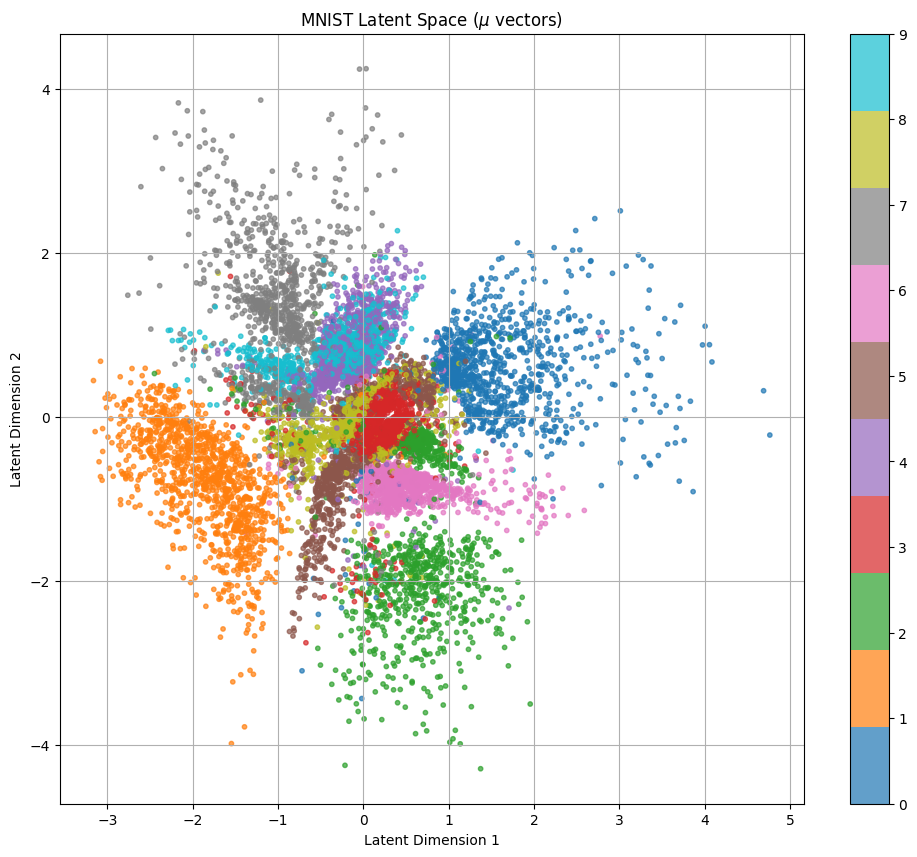

In [ ]:
def plot_latent_space():
    if LATENT_DIM != 2:
        print("Latent space visualization is only for LATENT_DIM=2.")
        print(f"Current LATENT_DIM is {LATENT_DIM}.")
        return

    model.eval()
    latent_vectors = []
    labels_list = []
    with torch.no_grad():
        for data, labels in test_loader: # Use test_loader for a manageable number of points
            data = data.to(DEVICE)
            mu, _ = model.encode(data.view(-1, INPUT_DIM))
            latent_vectors.append(mu.cpu())
            labels_list.append(labels.cpu())

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels_list = torch.cat(labels_list).numpy()

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels_list, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('MNIST Latent Space ($\mu$ vectors)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

plot_latent_space()

## 9. Conclusion

This notebook provided a step-by-step implementation of a Variational Autoencoder in PyTorch.

Key takeaways:
- **Encoder $q_\phi(z|x)$**: Maps input $x$ to parameters $(\mu, \log \sigma^2)$ of a Gaussian latent distribution.
- **Reparameterization Trick**: $z = \mu + \sigma \odot \epsilon$, enabling backpropagation through the sampling process.
- **Decoder $p_\theta(x|z)$**: Maps latent sample $z$ back to reconstruct $x$.
- **Loss Function (ELBO)**: Combines reconstruction loss (e.g., BCE) and KL divergence to regularize the latent space.

VAEs are powerful generative models capable of learning complex data distributions and generating new, realistic samples.

## Visualising function for latent space interpolation between two samples.


--- Static Interpolation Plot (10 steps) ---
Generating 10 steps for static plot.


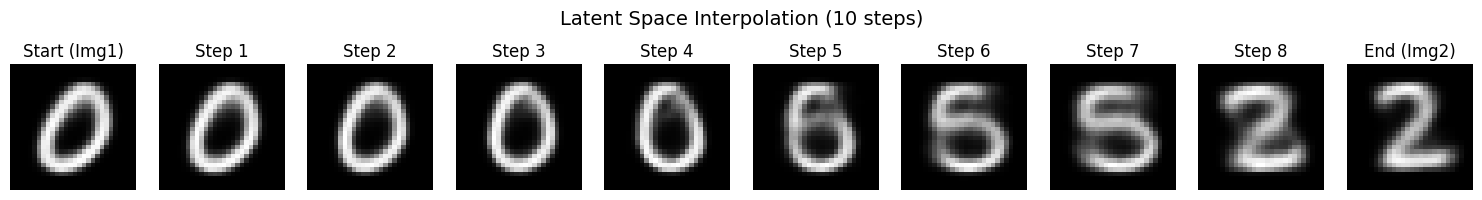


--- Static Interpolation Plot (Specific Images) ---
Interpolating between image index 3 (digit 0) and 0 (digit 7)
Generating 10 steps for static plot.


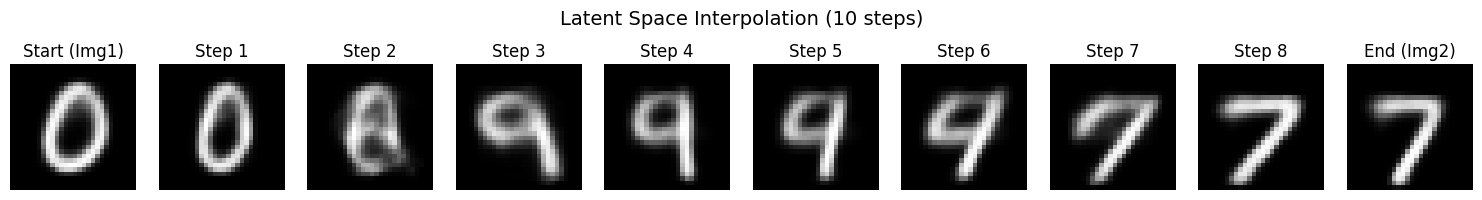


--- Animation Interpolation (3 seconds, 30fps) ---
Generating 90 frames for animation.


Animation displayed. If not visible, ensure ffmpeg is installed or try saving to file.

--- Animation Interpolation (M=60 frames) ---
Generating 60 frames for animation.


In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML # For displaying animation in Jupyter

def interpolate_latent_space(model, data_loader,
                             img1_idx=None, img2_idx=None,
                             num_steps=10, # Total plots including endpoints for static viz
                             animation_frames=None, # M steps for animation
                             animation_fps=30,
                             animation_duration_sec=None, # Alternative to animation_frames
                             device=DEVICE):
    """
    Encodes two images, interpolates between their latent representations (mu),
    decodes the intermediate points, and visualizes them either as a static plot
    or as an animation.

    Args:
        model (nn.Module): The trained VAE model.
        data_loader (DataLoader): DataLoader for the test set.
        img1_idx (int, optional): Index of the first image. If None, uses first from batch.
        img2_idx (int, optional): Index of the second image. If None, uses second from batch.
        num_steps (int): Number of steps for static plot (includes endpoints).
        animation_frames (int, optional): Total number of frames for animation (M).
                                         Overrides animation_duration_sec if set.
        animation_fps (int): Frames per second for the animation.
        animation_duration_sec (int, optional): Desired duration of the animation in seconds.
                                             If set, animation_frames = fps * duration.
        device (torch.device): Device to run computations on.

    Returns:
        matplotlib.animation.FuncAnimation or None: The animation object if animation is generated,
                                                    otherwise None.
    """
    model.eval()

    # Get the two images
    if img1_idx is not None and img2_idx is not None:
        img1_tensor, _ = data_loader.dataset[img1_idx]
        img2_tensor, _ = data_loader.dataset[img2_idx]
        img1_tensor = img1_tensor.unsqueeze(0).to(device) # Add batch dim
        img2_tensor = img2_tensor.unsqueeze(0).to(device)
    else:
        # Fetch a batch of 2 images
        try:
            images_batch, _ = next(iter(data_loader))
            if images_batch.size(0) < 2:
                print("DataLoader did not provide at least 2 images. Please ensure batch_size >= 2 or specify indices.")
                return None
            img1_tensor = images_batch[0].unsqueeze(0).to(device)
            img2_tensor = images_batch[1].unsqueeze(0).to(device)
        except StopIteration:
            print("DataLoader is empty.")
            return None

    with torch.no_grad():
        # Encode both images to get their latent means (mu)
        mu1, _ = model.encode(img1_tensor.view(1, -1))
        mu2, _ = model.encode(img2_tensor.view(1, -1))

        # Determine number of interpolation points for animation or static plot
        if animation_frames is not None or animation_duration_sec is not None:
            if animation_frames:
                interp_points_count = animation_frames
            else: # animation_duration_sec is set
                interp_points_count = int(animation_fps * animation_duration_sec)
            is_animation = True
            print(f"Generating {interp_points_count} frames for animation.")
        else:
            interp_points_count = num_steps
            is_animation = False
            print(f"Generating {interp_points_count} steps for static plot.")


        # Create interpolated latent vectors (linear interpolation between mu1 and mu2)
        interpolated_latents = []
        alpha_values = torch.linspace(0, 1, interp_points_count).to(device)

        for alpha in alpha_values:
            interpolated_mu = (1 - alpha) * mu1 + alpha * mu2
            interpolated_latents.append(interpolated_mu)
        interpolated_latents = torch.cat(interpolated_latents, dim=0)

        # Decode all interpolated latent vectors
        decoded_images = model.decode(interpolated_latents)
        decoded_images = decoded_images.view(interp_points_count, 1, 28, 28).cpu().numpy() # Reshape for plotting

    if is_animation:
        fig_anim, ax_anim = plt.subplots(figsize=(4, 4))
        ax_anim.axis('off')
        img_display = ax_anim.imshow(decoded_images[0, 0], cmap='gray', animated=True)

        def update_frame(i):
            img_display.set_array(decoded_images[i, 0])
            ax_anim.set_title(f"Frame: {i+1}/{interp_points_count}")
            return img_display,

        anim = animation.FuncAnimation(fig_anim, update_frame, frames=interp_points_count,
                                       interval=1000/animation_fps, blit=True, repeat=False)
        plt.close(fig_anim) # Close the static plot window for animation
        return anim
    else: # Static plot
        cols = interp_points_count
        rows = 1
        fig_static, axes_static = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5 + 0.5))
        if cols == 1: axes_static = [axes_static] # Handle single plot case

        for i in range(cols):
            axes_static[i].imshow(decoded_images[i, 0], cmap='gray')
            axes_static[i].axis('off')
            if i == 0:
                axes_static[i].set_title("Start (Img1)")
            elif i == cols - 1:
                axes_static[i].set_title("End (Img2)")
            else:
                axes_static[i].set_title(f"Step {i}")

        plt.suptitle(f"Latent Space Interpolation ({interp_points_count} steps)", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        return None

test_loader_interp = DataLoader(test_dataset, batch_size=2, shuffle=True)

# --- Example Usage ---

# 1. Static Plot with 10 steps (including endpoints)
print("\n--- Static Interpolation Plot (10 steps) ---")
interpolate_latent_space(model, test_loader_interp, num_steps=10)

# 2. Static Plot with specific images (e.g., image 0 and image 7 from test set)
print("\n--- Static Interpolation Plot (Specific Images) ---")
# Find indices of a '0' and a '7' for a more interesting interpolation
try:
    idx_0 = np.where(test_dataset.targets == 0)[0][0]
    idx_7 = np.where(test_dataset.targets == 7)[0][0]
    print(f"Interpolating between image index {idx_0} (digit 0) and {idx_7} (digit 7)")
    interpolate_latent_space(model, test_loader_interp, img1_idx=idx_0, img2_idx=idx_7, num_steps=10)
except IndexError:
    print("Could not find specific digits 0 and 7 for interpolation demo.")


# 3. Animation (e.g., 3 seconds at 30 fps = 90 frames)
# Make sure you have ffmpeg installed if you want to save the animation or display it robustly.
# `conda install ffmpeg` or `sudo apt-get install ffmpeg`
print("\n--- Animation Interpolation (3 seconds, 30fps) ---")
# To display in Jupyter Notebook:
anim_object = interpolate_latent_space(model, test_loader_interp,
                                       animation_duration_sec=3, animation_fps=30)
if anim_object:
    # Display the animation in Jupyter
    # Note: This might require ffmpeg to be installed and accessible.
    # If HTML(anim_object.to_html5_video()) doesn't work, try anim_object.save('interpolation.gif', writer='imagemagick', fps=30)
    # or anim_object.save('interpolation.mp4', writer='ffmpeg', fps=30)
    try:
        display(HTML(anim_object.to_html5_video()))
        print("Animation displayed. If not visible, ensure ffmpeg is installed or try saving to file.")
    except Exception as e:
        print(f"Could not display animation inline: {e}")
        print("Try saving the animation to a file instead, e.g., anim_object.save('interpolation.mp4')")
        # Example of saving:
        # anim_object.save('interpolation.mp4', writer='ffmpeg', fps=30)
        # print("Animation saved to interpolation.mp4")

# 4. Animation with a specific number of frames (M)
print("\n--- Animation Interpolation (M=60 frames) ---")
anim_object_m_frames = interpolate_latent_space(model, test_loader_interp,
                                                animation_frames=60, animation_fps=20) # 60 frames at 20fps = 3s
if anim_object_m_frames:
    try:
        display(HTML(anim_object_m_frames.to_html5_video()))
    except Exception as e:
        print(f"Could not display animation inline: {e}")

## latent space visualisation


--- PCA Plot of Latent Space (mu vectors) ---


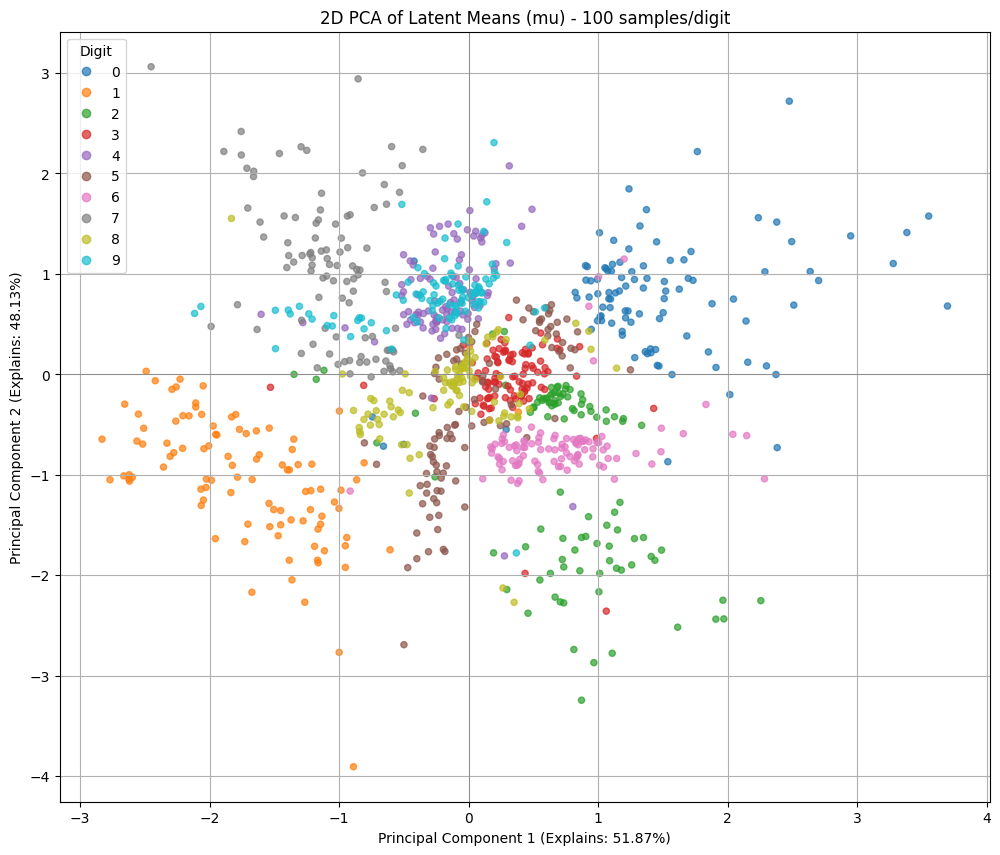

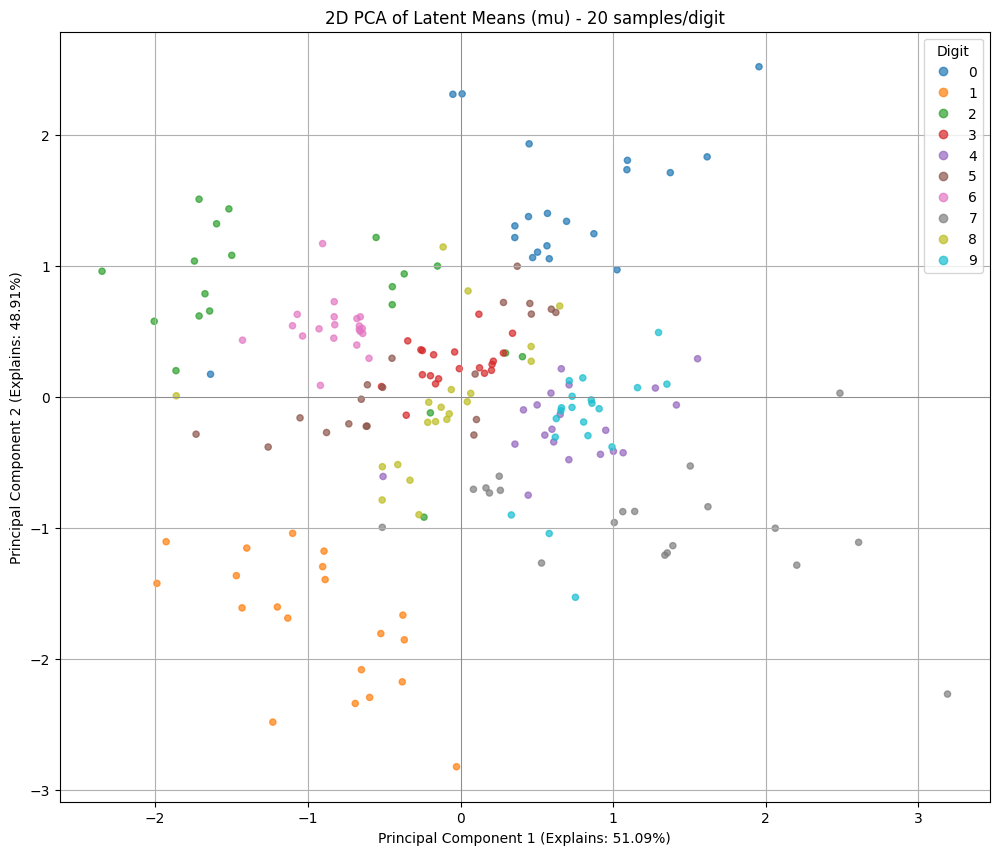

In [ ]:
from sklearn.decomposition import PCA

def plot_latent_pca(model, dataset, samples_per_digit=10000, device=DEVICE):
    """
    Takes samples for each digit, encodes them, performs PCA on the latent means (mu),
    and plots the first two principal components, colored by digit label.

    Args:
        model (nn.Module): The trained VAE model.
        dataset (torch.utils.data.Dataset): The dataset to sample from (e.g., test_dataset_full).
        samples_per_digit (int): Number of samples to take for each digit (0-9).
        device (torch.device): Device to run computations on.
    """
    model.eval() # Set model to evaluation mode
    all_latent_mus = []
    all_labels = []

    # Get targets if dataset provides them directly (like torchvision.datasets.MNIST)
    try:
        targets = dataset.targets.numpy() if hasattr(dataset.targets, 'numpy') else np.array(dataset.targets)
    except AttributeError:
        # Fallback if .targets isn't directly available or not a tensor (e.g. custom dataset)
        # This part might need adjustment for different dataset structures
        print("Warning: Could not access dataset.targets directly. Trying to iterate to get labels.")
        temp_loader = DataLoader(dataset, batch_size=10000, shuffle=False)
        all_targets_list = []
        for _, labels_batch in temp_loader:
            all_targets_list.append(labels_batch)
        targets = torch.cat(all_targets_list).numpy()


    for digit in range(10): # For digits 0 through 9
        # Get indices for the current digit
        digit_indices = np.where(targets == digit)[0]

        if len(digit_indices) == 0:
            print(f"Warning: No samples found for digit {digit} in the dataset.")
            continue

        # Randomly select 'samples_per_digit' indices for the current digit
        if len(digit_indices) < samples_per_digit:
            print(f"Warning: Fewer than {samples_per_digit} samples found for digit {digit}. Using all {len(digit_indices)} samples.")
            selected_indices = digit_indices
        else:
            selected_indices = np.random.choice(digit_indices, samples_per_digit, replace=False)

        # Create a Subset and DataLoader for these selected samples
        subset = torch.utils.data.Subset(dataset, selected_indices)
        data_loader_subset = DataLoader(subset, batch_size=samples_per_digit, shuffle=False) # Process all in one batch

        with torch.no_grad():
            for images, labels_batch in data_loader_subset: # Should be just one batch
                images = images.to(device)
                images_flat = images.view(images.size(0), -1)

                # Encode the images to get latent means (mu)
                # We use mu for PCA as it represents the center of the learned distribution for each image
                latent_mu, _ = model.encode(images_flat)

                all_latent_mus.append(latent_mu.cpu().numpy())
                all_labels.append(labels_batch.cpu().numpy()) # Store labels corresponding to these mus

    if not all_latent_mus:
        print("No latent variables collected. Cannot perform PCA.")
        return

    all_latent_mus = np.concatenate(all_latent_mus, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Perform PCA
    if all_latent_mus.shape[1] < 2:
        print(f"Latent dimension ({all_latent_mus.shape[1]}) is less than 2. Cannot plot 2D PCA.")
        if all_latent_mus.shape[1] == 1: # Plot 1D if possible
            plt.figure(figsize=(10, 2))
            for digit in range(10):
                digit_mus = all_latent_mus[all_labels == digit]
                if digit_mus.shape[0] > 0:
                    plt.scatter(digit_mus[:, 0], np.zeros_like(digit_mus[:, 0]) + digit * 0.1, label=str(digit), alpha=0.7, s=15)
            plt.yticks([])
            plt.xlabel("Principal Component 1")
            plt.title("1D PCA of Latent Means (mu)")
            plt.legend(title="Digit")
            plt.grid(True, axis='x')
            plt.show()
        return

    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(all_latent_mus)

    # Plot the 2D PCA results
    plt.figure(figsize=(12, 10))
    # `c=all_labels` uses the digit labels to color the points
    # `cmap='tab10'` is a good colormap for 10 distinct categories
    scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=all_labels, cmap='tab10', alpha=0.7, s=20)

    # Create a legend
    handles, _ = scatter.legend_elements(prop='colors') # Get handles for legend based on colors
    # Ensure legend labels match the actual digits present and their order in cmap
    unique_labels_sorted = np.unique(all_labels)
    legend_labels = [str(l) for l in unique_labels_sorted]

    plt.legend(handles, legend_labels, title="Digit")
    plt.xlabel(f"Principal Component 1 (Explains: {pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"Principal Component 2 (Explains: {pca.explained_variance_ratio_[1]*100:.2f}%)")
    plt.title(f"2D PCA of Latent Means (mu) - {samples_per_digit} samples/digit")
    plt.grid(True)
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.show()

test_dataset_full = datasets.MNIST('./data', train=False, download=True, transform=transform)
# --- Example Usage ---
# Use the full test dataset for sampling
print("\n--- PCA Plot of Latent Space (mu vectors) ---")
# If LATENT_DIM < 2, this function will try to plot 1D or print a message.
plot_latent_pca(model, test_dataset_full, samples_per_digit=100)
plot_latent_pca(model, test_dataset_full, samples_per_digit=20) # Fewer samples for a quicker plot